# Car Insurance Claim Linear Regression Model



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 100
import warnings

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def col_rename(df, dict_rules, ip=True):
    ''' rename columns in data frame using a dictionary of rules  '''
    if isinstance(df,pd.core.frame.DataFrame) and isinstance(dict_rules,dict):
        z = df.rename(columns = dict_rules, inplace=ip)
    else:
        raise TypeError
    return z
#
def print_unique(df,col):
    ''' gives a list of unique values in a field '''
    if isinstance(df,pd.core.frame.DataFrame) and isinstance(col,pd.core.frame.Series):
        z = df[col].unique()
    else:
        raise TypeError
    return z
#
def lower_case_column_names(df):
    ''' make columns lower case '''
    if isinstance(df,pd.core.frame.DataFrame):
        df.columns= [i.lower() for i in df.columns]
        df.columns = df.columns.str.replace(' ', '_')
    else:
        raise TypeError
    return df

def Remove_Outlier_Indices(df):
    """ returns a df of boolean values to used to index a trimmed table in the 1.5*IQR range"""
    if isinstance(df,pd.core.frame.DataFrame):
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        trueList = ~((df < (Q1 - 1.5*IQR)) |(df > (Q3 + 1.5*IQR)))
    else:
        raise TypeError
    return trueList

In [3]:
c2_df = pd.read_csv('../Data/Data_Marketing_Customer_Analysis_Round3.csv')

In [4]:
# remove the discrete fields
#c2_df.drop(['number_of_open_complaints','number_of_policies'],axis=1,inplace=True)

In [5]:
c2_df

,Unnamed: 0,region,customer_lifetime_value,response,coverage,education,effective_to_date,month,employment_status,gender,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,0,central,4809,no,basic,college,2/18/11,feb,employed,m,...,52,0,9,corporate auto,corporate l3,offer3,agent,292,four-door car,medsize
1,1,west region,2228,no,basic,college,1/18/11,jan,unemployed,f,...,26,0,1,personal auto,personal l3,offer4,call center,744,four-door car,medsize
2,2,east,14947,no,basic,bachelor,2/10/11,feb,employed,m,...,31,0,2,personal auto,personal l3,offer3,call center,480,suv,medsize
3,3,north west,22332,yes,extended,college,1/11/11,jan,employed,m,...,3,0,2,corporate auto,corporate l3,offer2,branch,484,four-door car,medsize
4,4,north west,9025,no,premium,bachelor,1/17/11,jan,medical leave,f,...,31,1,7,personal auto,personal l2,offer1,branch,707,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,10684,central,15563,no,premium,bachelor,1/19/11,jan,unemployed,f,...,40,2,7,personal auto,personal l1,offer3,web,1214,luxury car,medsize
10685,10685,north west,5259,no,basic,college,1/6/11,jan,employed,f,...,68,0,6,personal auto,personal l3,offer2,branch,273,four-door car,medsize
10686,10686,central,23893,no,extended,bachelor,2/6/11,feb,employed,f,...,63,0,2,corporate auto,corporate l3,offer1,web,381,luxury suv,medsize
10687,10687,west region,11971,no,premium,college,2/13/11,feb,employed,f,...,27,4,6,personal auto,personal l1,offer1,branch,618,suv,medsize


In [6]:
c2_df.columns

Index(['Unnamed: 0', 'region', 'customer_lifetime_value', 'response',
       'coverage', 'education', 'effective_to_date', 'month',
       'employment_status', 'gender', 'income', 'location_code',
       'marital_status', 'monthly_premium_auto', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'total_claim_amount', 'vehicle_class', 'vehicle_size'],
      dtype='object')

In [7]:
X = c2_df.drop(['total_claim_amount','effective_to_date'], axis=1) # trimmed target var
y = c2_df.total_claim_amount # trimmed independent var (vec)`

dM_n = X.select_dtypes(exclude=object)
dM_c = pd.get_dummies(X.select_dtypes(include=object))

# Index List of Non-Outliers
nonOutlierList = Remove_Outlier_Indices(dM_n)

dM_c = dM_c[nonOutlierList.all(1)]
dM_n = dM_n[nonOutlierList.all(1)]

X = pd.concat([dM_n,dM_c],axis=1)
y = y[nonOutlierList.all(1)]

In [8]:
TEST_SIZE = .25
RANDOM_STATE = 123 # reproduce the same results. disables randomization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,random_state=RANDOM_STATE)

In [9]:
transformer = StandardScaler()
transformer.fit(X_train)
X_test = transformer.transform(X_test)
X_train = transformer.transform(X_train)

### Apply linear regression model

In [10]:
model = LinearRegression()   # model is y = SUM(slopes*Xs) + intercept
model.fit(X_train, y_train) # compute for me the coefficients (slopes and intercept)
y_pred       = model.predict(X_test)   # model prediction [test]
y_pred_train = model.predict(X_train)  # model prediction [train]

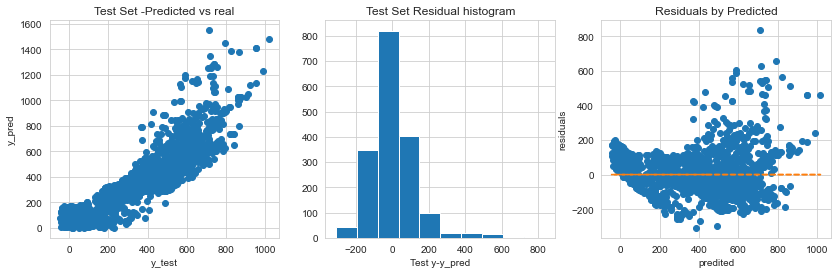

In [11]:
fig, ax = plt.subplots(1,3,figsize=(14,4))

# forms a line?
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

# constant?
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

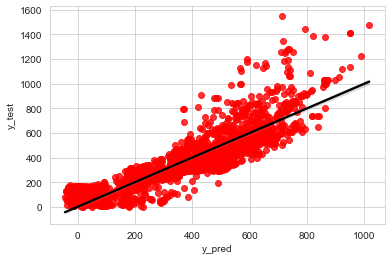

In [12]:
sns.regplot(x='y_pred',y='y_test', data=pd.DataFrame({"y_test": y_test, "y_pred": y_pred}) ,
            scatter_kws={"color": "red"}, line_kws={"color": "black"})

In [13]:
R2=r2_score(y_test,y_pred)
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
R2,Adj_R2

(0.7395693056886321, 0.7294584669683084)

In [15]:
import statsmodels.api as sm

In [17]:
X_train_const_ct = sm.add_constant(X_train) # adding a constant

model = sm.OLS(y_train, X_train_const_ct).fit()
predictions_train = model.predict(X_train_const_ct)

X_test_const_ct = sm.add_constant(X_test) # adding a constant
predictions_test = model.predict(X_test_const_ct)
print_model = model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     333.7
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:37:57   Log-Likelihood:                -32781.
No. Observations:                5299   AIC:                         6.566e+04
Df Residuals:                    5250   BIC:                         6.598e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        401.9612      1.720    233.666      0.0

In [ ]:
from statsmodels.formula.api import ols